In [17]:
import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats as stats

import arviz as az
import pymc as pm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

## Data

In [2]:
import zipfile, glob
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin

In [3]:
url = 'https://archive.ics.uci.edu/static/public/186/wine+quality.zip'
data_path = Path('data')
filename = data_path / url.split('/')[-1]

if not data_path.exists():
    print('Creating directory')
    data_path.mkdir()
if not filename.exists():
    print('Downloading...', url)
    urlretrieve(url, filename)

if filename.exists():
    extract_dir = 'data'
    print('Extracting files...')
    with zipfile.ZipFile(filename) as zf:
        zf.extractall(extract_dir)
    for file in glob.glob(extract_dir + '/**', recursive=True):
        print(file)

print('...DONE')

Creating directory
Downloading... https://archive.ics.uci.edu/static/public/186/wine+quality.zip
Extracting files...
data/
data/winequality.names
data/winequality-white.csv
data/winequality-red.csv
data/wine+quality.zip
...DONE


## EDA

In [6]:
white = pd.read_csv('data/winequality-white.csv', sep=';')
white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
white.shape

(4898, 12)

In [9]:
red = pd.read_csv('data/winequality-red.csv', sep=';')
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
red.shape

(1599, 12)

<Axes: >

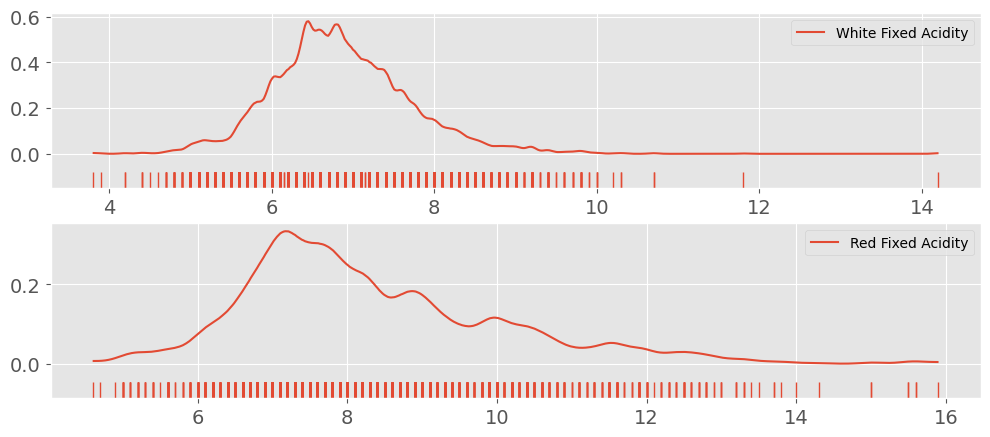

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
az.plot_kde(white['fixed acidity'].to_numpy(), rug=True, ax=axs[0], label='White Fixed Acidity')
az.plot_kde(red['fixed acidity'].to_numpy(), rug=True, ax=axs[1], label='Red Fixed Acidity')

In [31]:
white['fixed acidity'].to_numpy().mean(), white['fixed acidity'].to_numpy().std()

(6.854787668436097, 0.8437820791264506)

Output()

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sd'}>, <Axes: title={'center': 'sd'}>]],
      dtype=object)

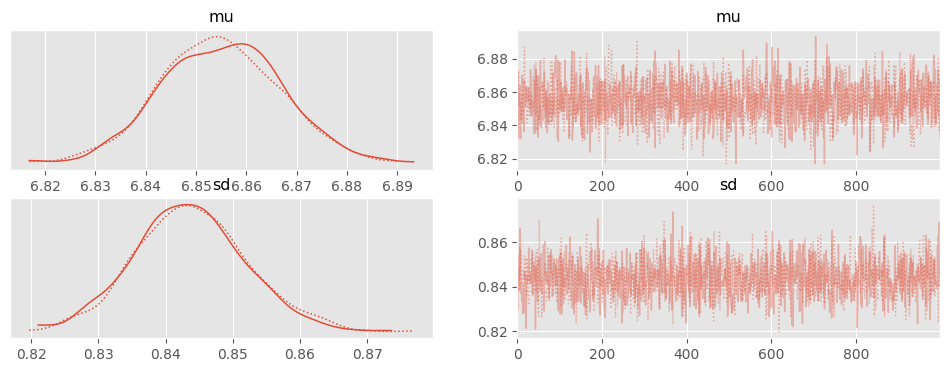

In [32]:
with pm.Model() as white_model:
    mu = pm.Uniform('mu', lower=0, upper=10)
    sd = pm.HalfNormal('sd', sigma=1)
    y = pm.Normal('y', mu=mu, sigma=sd, observed=white['fixed acidity'].to_numpy())
    trace_w = pm.sample(1000)
az.plot_trace(trace_w)

In [34]:
az.summary(trace_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,6.855,0.012,6.834,6.878,0.0,0.0,1810.0,1460.0,1.0
sd,0.844,0.008,0.828,0.859,0.0,0.0,1711.0,1328.0,1.0


Output()

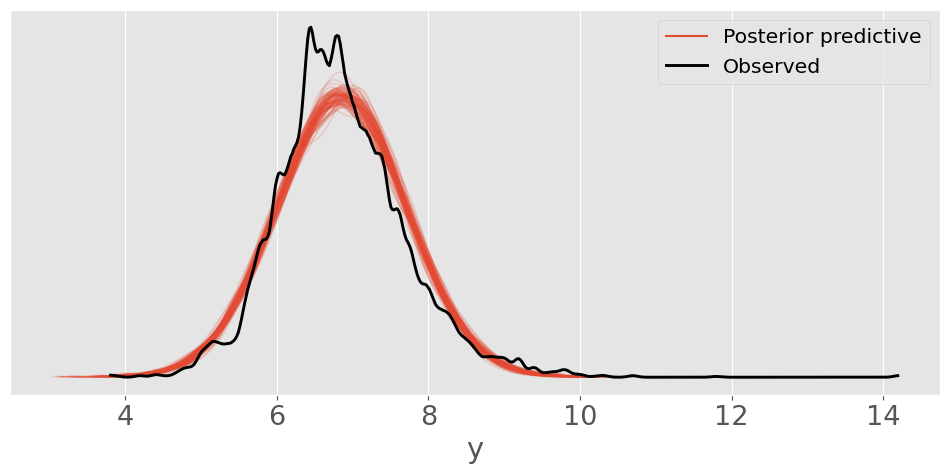

In [36]:
y_pred_w = pm.sample_posterior_predictive(trace_w, white_model,
                                          extend_inferencedata=True)
ax = az.plot_ppc(trace_w, num_pp_samples=100,
                 figsize=(12, 5), mean=False)